In [1]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

Text(0,0.5,'x, v')

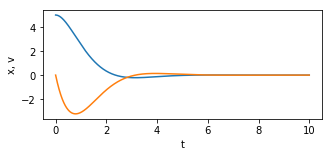

In [2]:
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

k = 2
b = 2
x0 = [5,0]
t = np.linspace(0,10,2000)
sol = odeint(fun, x0, t)

plt.figure(figsize=(5,2));
plt.plot(t,sol);
plt.xlabel('t')
plt.ylabel('x, v')

In [3]:
def CumExpDist(t,tau):
    return 1 - np.exp(-tau*t)

# Distributions Parameters
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
tau = 0.4

# Compute P_space and P_time 
N = 40
u = np.linspace(-10,10,N)
v = np.linspace(-10,10,N)
T = np.linspace(0,10,N)
U,V = np.meshgrid(u,v)
#
P = np.zeros((N,N))
P_exp = np.zeros((N,1))
for i in range(N):
    for j in range(N):
        x = np.array([U[i,j],V[i,j]])
        P[i,j] = multivariate_normal.pdf(x,mu,Sigma)
    P_exp[i] = CumExpDist(T[i],tau)
    

# Compute Total Probability
X = -5 + 10*np.random.rand(10000,2)
X = np.hstack((X,5*np.random.rand(10000,1)))
#
P_tot = [multivariate_normal.pdf(x[:2],mu,Sigma)*CumExpDist(x[2],tau) for x in X]

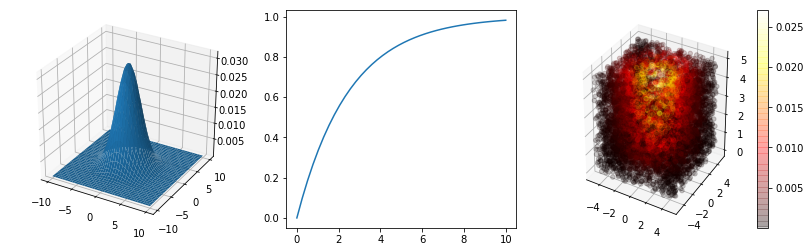

In [4]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U, V, P)
ax2 = fig.add_subplot(132)
ax2.plot(T, P_exp)
ax3 = fig.add_subplot(133, projection='3d')
density = ax3.scatter(X[:,0], X[:,1], X[:,2], c=P_tot, cmap=plt.hot(), alpha = 0.2)
fig.colorbar(density)

In [5]:
#
p_sol = np.array([multivariate_normal.pdf(sol[i],mu,Sigma) for i in range(len(sol))])#np.array([SpatialExpDist(sol[i],0.01) for i in range(len(sol))])#
p_t = np.array([CumExpDist(t[i],0.2) for i in range(len(sol))])
P = np.multiply(p_sol,p_t)

In [6]:
Event_flag = np.array([np.random.binomial(1,P[i]) for i in range(len(sol))])

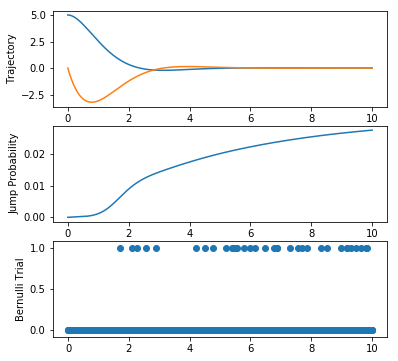

In [7]:
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.plot(t,sol)
plt.ylabel('Trajectory')
plt.subplot(312)
plt.plot(t,P)
plt.ylabel('Jump Probability')
plt.subplot(313)
plt.ylabel('Bernulli Trial')
plt.scatter(t,Event_flag)

In [8]:
Event_index = []
for i in range(len(Event_flag)):
    if Event_flag[i]>0:
        Event_index.append(i)
Event_states = sol[Event_index]

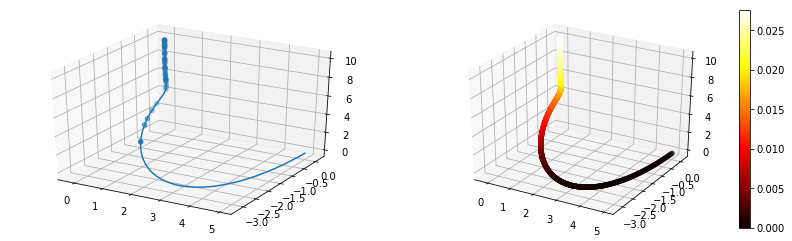

In [9]:
import matplotlib
cmap = matplotlib.cm.get_cmap('hot')
normalize = matplotlib.colors.Normalize(vmin=min(P), vmax=max(P))
colors = [cmap(normalize(value)) for value in P]

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(sol[:,0],sol[:,1],t)
ax1.scatter(Event_states[:,0],Event_states[:,1], t[Event_index].reshape(-1,1))
#
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(sol[:,0], sol[:,1], t.reshape(-1,1), color=colors)
ax2.scatter(Event_states[0,0],Event_states[0,1])
cax, _ = matplotlib.colorbar.make_axes(ax2)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)


# Generate Data

### Simulate Hybrid System 

In [10]:
#jump map
def jump(x,t):
    mu = (x + 1*np.random.randn(1,2)).tolist()
    Sigma = [[5,0],[0,5]]
    return np.random.multivariate_normal(mu[0],Sigma)

from pyPDMP.utils import HDSint
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau) 

Progress:
25.0
50.0
75.0
100.0


In [11]:
def TotalJumpProb(x,t):
    return multivariate_normal.pdf(x,mu,Sigma)*CumExpDist(t,tau)

Ptot = [TotalJumpProb(Xtot[i,:2],Xtot[i,2]) for i in range(len(Xtot))]

<IPython.core.display.Javascript object>


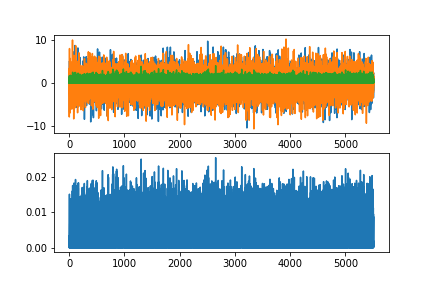

In [41]:
%matplotlib notebook

plt.figure()
plt.subplot(211)
plt.plot(Ttot, Xtot)
plt.subplot(212)
plt.plot(Ttot, Ptot)
plt.draw()

In [13]:
cmap = matplotlib.cm.get_cmap('hot')
normalize = matplotlib.colors.Normalize(vmin=min(Ptot), vmax=max(Ptot))
colors = [cmap(normalize(value)) for value in Ptot]

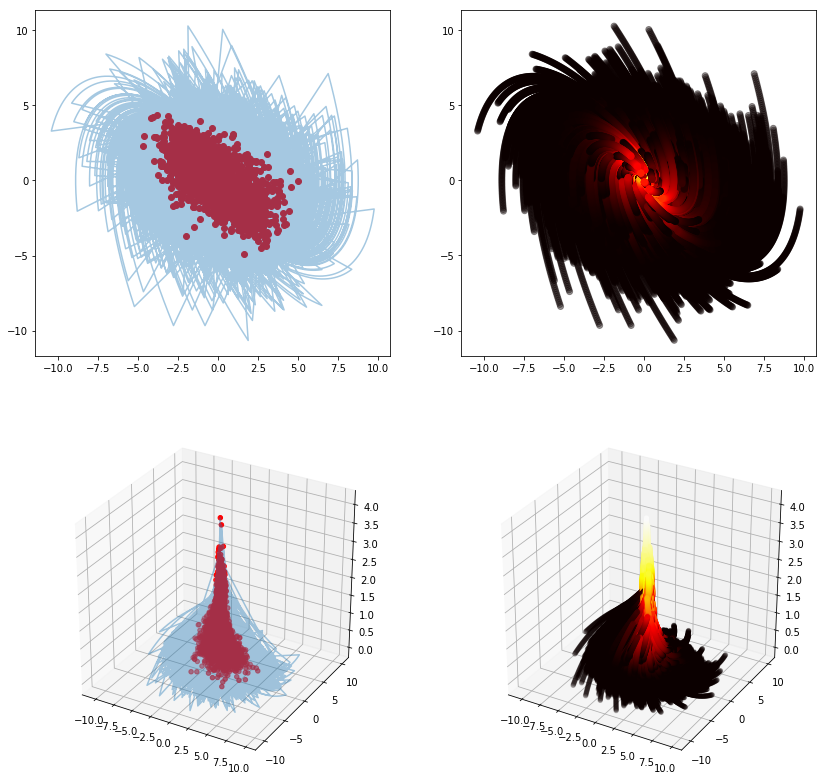

In [39]:
%matplotlib inline

fig = plt.figure(figsize=(14, 14));
ax1 = fig.add_subplot(221);
ax1.plot(Xtot[:,0],Xtot[:,1],alpha = 0.4);
ax1.scatter(Xevent[:,0],Xevent[:,1],color = 'red');
#
ax2 = fig.add_subplot(222);
ax2.scatter(Xtot[:,0], Xtot[:,1], color=colors, alpha = 0.4);
#
ax3 = fig.add_subplot(223,  projection='3d');
ax3.plot(Xtot[:,0],Xtot[:,1], Xtot[:,2], alpha = 0.4);
ax3.scatter(Xevent[:,0],Xevent[:,1], Xevent[:,2], color = 'red');
#
ax4 = fig.add_subplot(224,  projection='3d');
ax4.scatter(Xtot[:,0], Xtot[:,1], Xtot[:,2],  color=colors, alpha = 0.2);

### Analize Statistical Properties of the Data

In [15]:
def PlotJointDensity(x,y, bins, label, fig = fig, grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)):
    main_ax = fig.add_subplot(grid[1:, :-1])
    y_hist = fig.add_subplot(grid[1:, -1], yticklabels=[])
    x_hist = fig.add_subplot(grid[0, :-1], xticklabels=[])

    # histogram on the attached axes
    x_hist.hist(x, bins, histtype='stepfilled',
            orientation='vertical', color='gray', density = True)

    y_hist.hist(y, bins, histtype='stepfilled',
            orientation='horizontal', color='gray',density = True)

    # scatter points on the main axes
    main_ax.hexbin(x,y,gridsize=bins,cmap='gray_r')
    main_ax.set_xlabel(label[0])
    main_ax.set_ylabel(label[1])
    
# fig = plt.figure(figsize=(6,6))
# PlotJointDensity(Xevent[:,0],Xevent[:,1], 20, ["$x_{event}$","$y_{event}$"], fig)

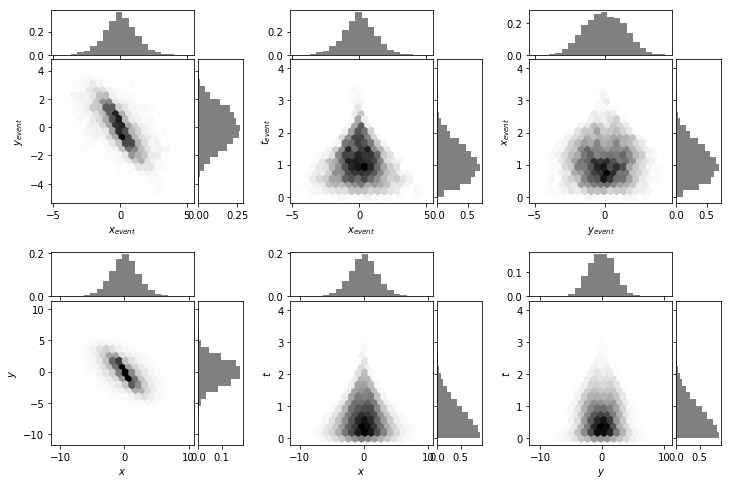

In [16]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))
outer = gridspec.GridSpec(2, 3, wspace=0.25, hspace=0.25)

for i in range(6):
    inner = gridspec.GridSpecFromSubplotSpec(4, 4,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    if i == 0:
        PlotJointDensity(Xevent[:,0],Xevent[:,1], 20, ["$x_{event}$","$y_{event}$"], fig, inner)
    elif i == 1:
        PlotJointDensity(Xevent[:,0],Xevent[:,2], 20, ["$x_{event}$","$t_{event}$"], fig, inner)
    elif i == 2:
        PlotJointDensity(Xevent[:,1],Xevent[:,2], 20, ["$y_{event}$","$x_{event}$"], fig, inner)
    elif i == 3:
        PlotJointDensity(Xtot[:,0],Xtot[:,1], 20, ["$x$","$y$"], fig, inner)
    elif i == 4:
        PlotJointDensity(Xtot[:,0],Xtot[:,2], 20, ["$x$","$t$"], fig, inner)
    else:
        PlotJointDensity(Xtot[:,1],Xtot[:,2], 20, ["$y$","$t$"], fig, inner)

#     for j in range(2):
#         ax = plt.Subplot(fig, inner[j])
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
#         t.set_ha('center')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         fig.add_subplot(ax)

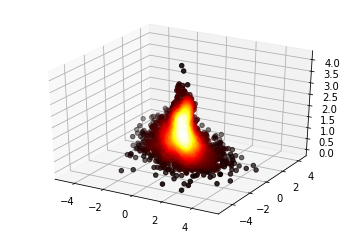

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
x = Xevent[1:,0]
y = Xevent[1:,1]
z = Xevent[1:,2]

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density,cmap=plt.hot())
plt.draw()
plt.show()

Fit jump points with a MoG 

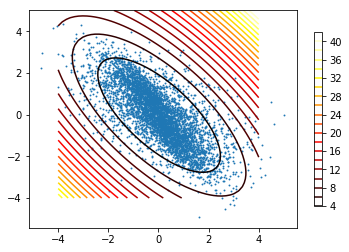

In [18]:
from matplotlib.colors import LogNorm
from sklearn import mixture

# Fit mixure of gaussian
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
clf.fit(np.hstack((Xevent[:,0].reshape(-1,1),Xevent[:,1].reshape(-1,1))))

x = np.linspace(-4., 4.)
y = np.linspace(-4., 5.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure()
CS = plt.contour(X, Y, Z,20)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(Xevent[1:,0], Xevent[1:,1], .8)
plt.show()

In [19]:
#x_event.mean(0)
Se = Xevent[:,:3].T.dot(Xevent[:,:3])/len(Xevent)
Se

array([[ 1.50174101, -1.20273594,  0.01377956],
       [-1.20273594,  1.88838391, -0.02323826],
       [ 0.01377956, -0.02323826,  1.53683486]])

### Analize Jump map 

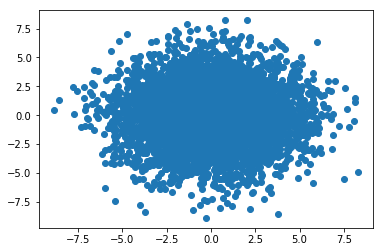

In [20]:
Xupdate = Xreset - Xevent[:,:2]

plt.figure()
plt.scatter(Xupdate[:,0],Xupdate[:,1])

# Jump Detection from trajectory

In [21]:
DXtot = [0]
i = len(Xtot)-1
print('Delete reapeated Samples...')
print('  Progress:')
while i>0:
    if Ttot[i]-Ttot[i-1] == 0:
        Ttot_r = np.delete(Ttot,i-1)
        Xtot_r = np.delete(Xtot,i-1,axis = 0)
    if (100*i)%((len(Xtot)-1))==0:
            print('  ',100-(100*i)/(len(Xtot)-1))
    i -= 1
print('Done.')

Delete reapeated Samples...
  Progress:
   0.0
   4.0
   8.0
   12.0
   16.0
   20.0
   24.0
   28.0
   32.0
   36.0
   40.0
   44.0
   48.0
   52.0
   56.0
   60.0
   64.0
   68.0
   72.0
   76.0
   80.0
   84.0
   88.0
   92.0
   96.0
Done.


In [22]:
def SmoothnessBound(x, x_, r):
    Df = [[0, 1, 0], [-k, -b, 0], [0, 0, 1]]
    nDf = np.linalg.norm(Df)
    Integral = np.linalg.norm(x)+np.linalg.norm(x_)
    return (r*nDf*Integral)/2


DeltaXtot = (Xtot_r[1:]-Xtot_r[:-1])/(Ttot[1]-Ttot[0])
DXtot = [np.linalg.norm(p) for p in DeltaXtot]

r = 2
S_b = [SmoothnessBound(Xtot[i],Xtot[i-1],r) for i in range(2,len(Xtot))]

<IPython.core.display.Javascript object>


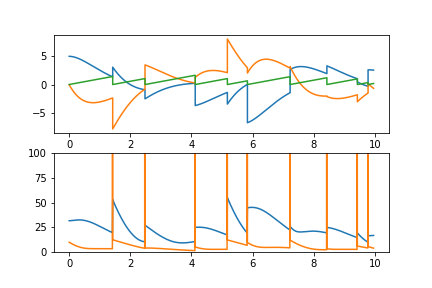

In [35]:
%matplotlib notebook 

plt.figure()
plt.subplot(211)
plt.plot(Ttot[1:1999],Xtot[1:1999])
plt.subplot(212)
plt.plot(Ttot[1:1999],S_b[1:1999])
plt.plot(Ttot[1:1999],DXtot[1:1999])
plt.ylim([0,100])
plt.show()

### Jump Detection with noisy obervations|
we add Gaussian noise on the observations of the state but on the time

In [36]:
noise_std = 0.05
Xtot_r_noisy = Xtot_r + noise_std*np.hstack((np.random.rand(len(Xtot_r),2),np.zeros((len(Xtot_r),1)))) 

DeltaXtot_noisy = (Xtot_r_noisy[1:]-Xtot_r_noisy[:-1])/(Ttot[1]-Ttot[0])
DXtot_noisy = np.array([np.linalg.norm(p) for p in DeltaXtot_noisy])

In [25]:
def NormSmoothnessBound(x, x_, r):
    Df = [[0, 1, 0], [-k, -b, 0], [0, 0, 1]]
    nDf = np.linalg.norm(Df)
    Integral = np.linalg.norm(x)+np.linalg.norm(x_)
    return (r*nDf*Integral)/(2)

r = 15
S_b_noisy = np.array([SmoothnessBound(Xtot_r_noisy[i],Xtot_r_noisy[i-1],r) for i in range(1,len(Xtot_r_noisy))])

In [26]:
def JumpDetector(Dx,Sb):
    if Dx<=Sb:
        return 0
    else:
        return 1
    
gamma = [JumpDetector(DXtot_noisy[i],S_b_noisy[i]) for i in range(len(DXtot_noisy))]

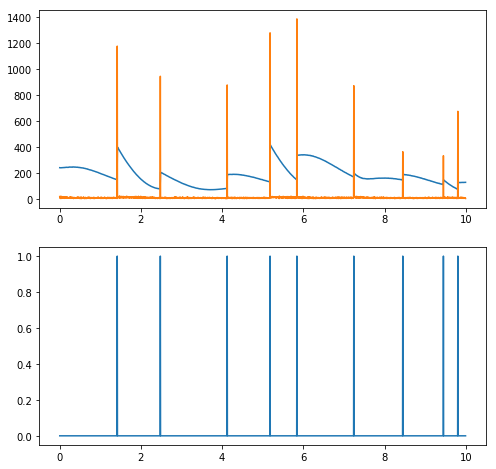

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t[1:1999],S_b_noisy[1:1999])
plt.plot(t[1:1999],DXtot_noisy[1:1999])
plt.subplot(212)
plt.plot(t[1:1999],gamma[1:1999])
#plt.ylim([0,100])
plt.show()